# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError
from math import exp,log

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1/(1+np.exp(-(X@weights.T)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        num_samples = x.shape[0]
        log_sum = 0
        for i in range (len(x)):
            xi,yi = x[i],y[i]
            log_sum += log(1+np.exp(-(xi@weights.T * yi)))
                  
        return log_sum/num_samples + 1/(2*self.C)*np.linalg.norm(weights)
     
    def fit(self, X, y,loss_calc=True):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features,num_samples = X_ext.shape[1],X_ext.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        
        iter_count = self.max_iter
        for i in range(self.max_iter):
            iter_count -= 1
            wt = self.weights_.copy()
            grad_sum = 0
            for m in range (len(X_ext)):
                xi,yi = X_ext[m],y[m]
                grad_sum += yi*xi*(1-(1/(1+np.exp(-(xi@self.weights_.T * yi)))))
            delta = grad_sum/num_samples - 1/self.C*wt**2
            self.weights_ -= self.eta * -delta
            #Loss function container
            self.loss.append(self.get_loss(X_ext,wt,y))
            
            if np.linalg.norm((self.weights_-wt)) < self.tol or iter_count == 0:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_pred = 1/(1+np.exp(-(X@self.weights_.T[1:])))
        y_pred[y_pred<0.5] = -1
        y_pred[y_pred>0.5] = 1
        return y_pred

In [5]:
from sklearn import datasets
from sklearn import metrics

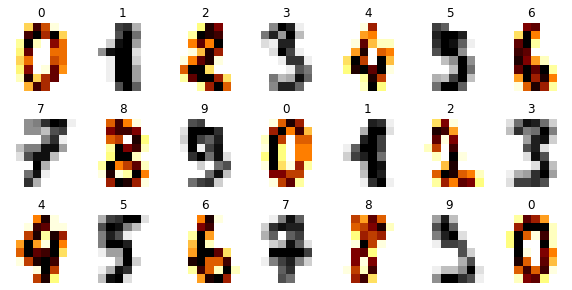

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

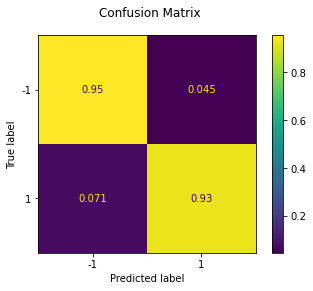

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9151009046624913, 0.9416666666666667)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0, 0.5, 'Loss value')

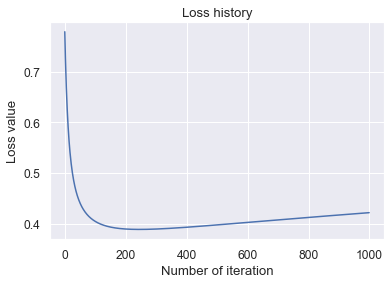

In [17]:
## your code
sns.set(font_scale=1.1,style='darkgrid')
sns.lineplot(x=np.arange(len(model.loss)),y=model.loss)
plt.title('Loss history')
plt.xlabel('Number of iteration')
plt.ylabel('Loss value')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
## your code
loss_eta = []
eta = [0.0001,0.0005,0.001,0.005,0.01,0.05]
for x  in eta:
    model = CustomLogisticRegression(eta=x,max_iter=500)
    model.fit(X_train, y_train)
    loss_eta.append(model.loss)

C:\Users\user\AppData\Local\Temp/ipykernel_4812/3500753724.py:69: RuntimeWarning: overflow encountered in exp
  grad_sum += yi*xi*(1-(1/(1+np.exp(-(xi@self.weights_.T * yi)))))
C:\Users\user\AppData\Local\Temp/ipykernel_4812/3500753724.py:40: RuntimeWarning: overflow encountered in exp
  log_sum += log(1+np.exp(-(xi@weights.T * yi)))
C:\Users\user\AppData\Local\Temp/ipykernel_4812/3500753724.py:70: RuntimeWarning: overflow encountered in square
  delta = grad_sum/num_samples - 1/self.C*wt**2
C:\Users\user\AppData\Local\Temp/ipykernel_4812/3500753724.py:69: RuntimeWarning: invalid value encountered in matmul
  grad_sum += yi*xi*(1-(1/(1+np.exp(-(xi@self.weights_.T * yi)))))
C:\Users\user\AppData\Local\Temp/ipykernel_4812/3500753724.py:40: RuntimeWarning: invalid value encountered in matmul
  log_sum += log(1+np.exp(-(xi@weights.T * yi)))


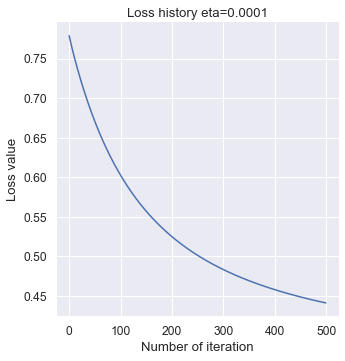

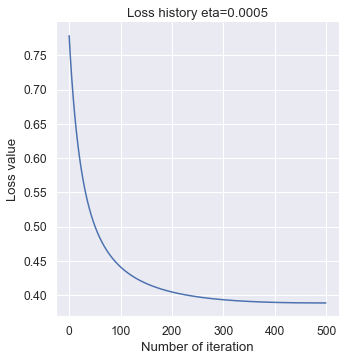

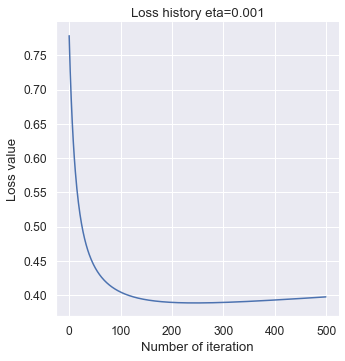

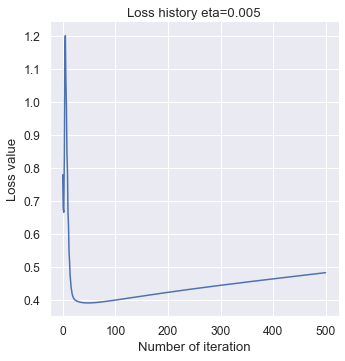

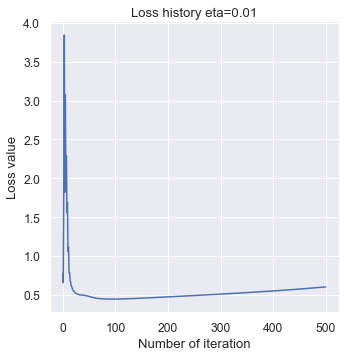

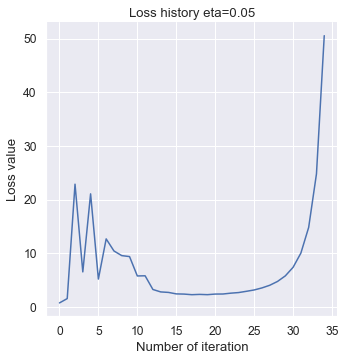

In [19]:
for x in range(len(loss_eta)):
    sns.relplot(x=np.arange(len(loss_eta[x])),y=loss_eta[x],kind='line')
    plt.title(f'Loss history eta={eta[x]}')
    plt.xlabel('Number of iteration')
    plt.ylabel('Loss value')

В данном случае можно сделать вывод о том, что самым оптимальным значением learning rate является 0.001, т.к. достигается наименьшего значения Loss за 200-300 операций и при этом модель получется очень хорошего качества

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [20]:
## your code
train_accur,test_accur = [],[]
c_val = [0.1,0.5,1.5,2]
for x  in c_val:
    model = CustomLogisticRegression(C=x,max_iter=500)
    model.fit(X_train, y_train,loss_calc=False)
    train_accur.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_accur.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    

In [21]:
train_accur

[0.9046624913013221,
 0.9109255393180237,
 0.9102296450939458,
 0.9109255393180237]

Text(-3.2439999999999998, 0.5, 'Accuracy')

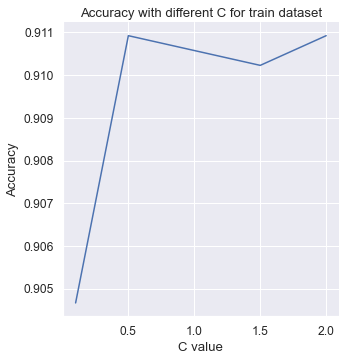

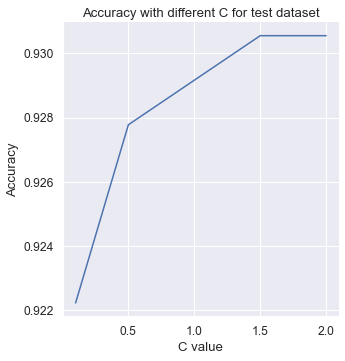

In [22]:
sns.relplot(x=c_val,y=train_accur,kind='line')
plt.title('Accuracy with different C for train dataset')
plt.xlabel('C value')
plt.ylabel('Accuracy')
sns.relplot(x=c_val,y=test_accur,kind='line')
plt.title('Accuracy with different C for test dataset')
plt.xlabel('C value')
plt.ylabel('Accuracy')

Accuracy растет (хотя и не значительно, но все же рост) с увеличением С. В данном случае наиболее оптимальное значение будет 1.0 или 1.5 (в случае 1.5 у тренировочного сета будет меньше accuracy, но в test получится лучше, чем с 1.0, но установка значений гиперпараметров производится только на тренировочном, поэтому лучше всего будет 1.0)

**(0.5 points)** Compare zero initialization and random initialization. 

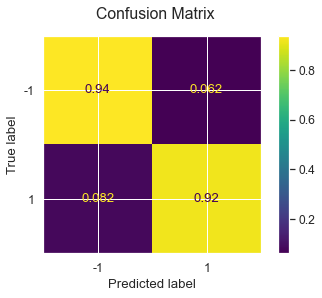

(0.9088378566457899, 0.9277777777777778)

In [23]:
## your code
model_non_zero = CustomLogisticRegression(zero_init=True,max_iter=500)
train_acc_nonzero, test_acc_nonzero = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_acc_nonzero, test_acc_nonzero

In [24]:
train_acc, test_acc

(0.9151009046624913, 0.9416666666666667)

In [25]:
import pandas as pd
df= pd.DataFrame({'Train':[train_acc_nonzero, train_acc],'Test':[test_acc_nonzero, test_acc],'Init':[0,1]})
df

,Train,Test,Init
0,0.908838,0.927778,0
1,0.915101,0.941667,1


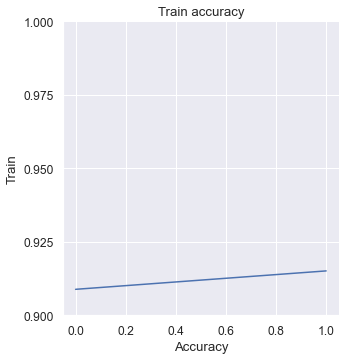

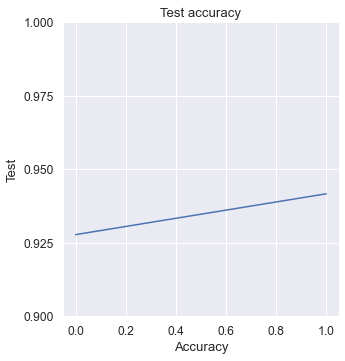

In [26]:
sns.relplot(x='Init',y='Train',data=df,kind='line').set(title='Train accuracy',xlabel='Accuracy',yticks=np.linspace(0.9,1,5))
sns.relplot(x='Init',y='Test',data=df,kind='line').set(title='Test accuracy',xlabel='Accuracy',yticks=np.linspace(0.9,1,5))

И для теста, и для тренировки accuracy растет при использовании ненулевой инициализации. В данном случае лучше использовать ненулевую инициализацию, чтобы добиться улучшения качества модели

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [27]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.classes_ = []
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        XX,YY,dist=[],[],[]
        for x in range(len(X)):
            XX.append(np.round(np.linalg.norm(X[x])**2,5))
        for u in range(len(Y)):
            YY.append(np.round(np.linalg.norm(Y[u])**2,5))
        XX,YY = np.array(XX).reshape(-1,1),np.array(YY)
        dist = X @ Y.T * (-2)
        dist += XX
        dist += YY
        return dist ** 0.5
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        res_w = []
        for i in self.classes_:
            s=0
            res = np.where(y == str(i))
            for m in res:
                s+=weights[m]
                res_w.append(np.sum(s))
        return np.array(res_w)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P+self.eps)
            probability = []
            for x in P:
                k_idx = np.argsort(x)
                k_neighbor_labels = np.array([self.y[i] for i in k_idx])
                dists = np.array([x[i] for i in k_idx])
                w = 1/dists+self.eps

                prob = []
                for u in self.classes_:
                    e = np.where(k_neighbor_labels == int(u))
                    prob.append(np.sum(w[e]))
                prob = np.array(prob)
                prob /= np.sum(prob)
                prob[np.argsort(prob)[-1]]=1
                prob[prob<np.max(prob)] = 0

                probability.append(prob.tolist())
            return np.array(probability)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [28]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [29]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [30]:
model.classes_ = ['one', 'two', 'three']
model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4]))

array([2, 4, 0])

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

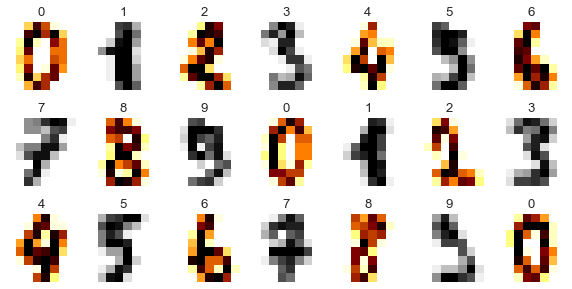

In [32]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

#### Сорян, но мой уровень знаний не позволяет без каких либо практических примеров разобраться в теме, которая для меня новая всецело. Конкретно данный модуль можно было вообще не проводить, а просто дать домашку, результат был бы такой же
#### Конкретно во 2 задании я разобрался только с расстоянием и классовым весом, а реализовать дальше не получилось, переходите к 3 заданию

In [33]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

NotFittedError: CustomKNeighborsClassifier instance is not fitted yet

In [34]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

ValueError: Expected array-like (array or non-string sequence), got None

In [35]:
assert train_acc == 1
assert test_acc > 0.98

AssertionError: 

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [36]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [37]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [38]:
PATH = "./data/"

In [39]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [40]:
data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

[Text(0.5, 1.0, '% рапределения выживания/смертности мужчин и женщин'),
 Text(0, 0.5, '%'),
 Text(0.5, 0, 'Погибли - 0, Выжили - 1'),

<Figure size 432x288 with 0 Axes>

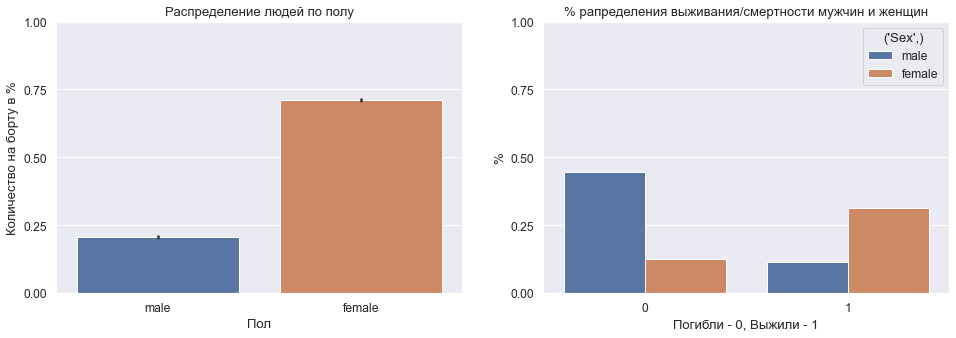

In [41]:
## your code
%matplotlib inline
df_sex = data[['Survived','Sex']].value_counts(normalize=True).reset_index()
df_sex.columns = [['Survived','Sex','Survived_perc']]
plt.subplots_adjust(wspace=5,hspace=5)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.barplot(x = data.Sex,y=data.Survived).set(title='Распределение людей по полу',\
                                              ylabel='Количество на борту в %',xlabel='Пол',yticks=np.linspace(0,1,5))
plt.subplot(1,2,2)
sns.barplot(x=df_sex.iloc[:,0],y=df_sex.iloc[:,2],hue=df_sex.iloc[:,1]).set(title='% рапределения выживания/смертности мужчин и женщин',\
                                         ylabel='%',xlabel='Погибли - 0, Выжили - 1' ,yticks=np.linspace(0,1,5))

Возможно, что корреляция существует потому, что сперва пытались спасти женщин и детей, усаживая их в лодки, остальные спасались просто прыгнув в воду (мужчины)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [42]:
#Display median and mean age for survived/not survived passangers
data.groupby(by='Survived').agg(['mean','median'])['Age']

,mean,median
Survived,,
0,36.708695,36.0
1,40.553799,43.0


<AxesSubplot:xlabel='Age', ylabel='Density'>

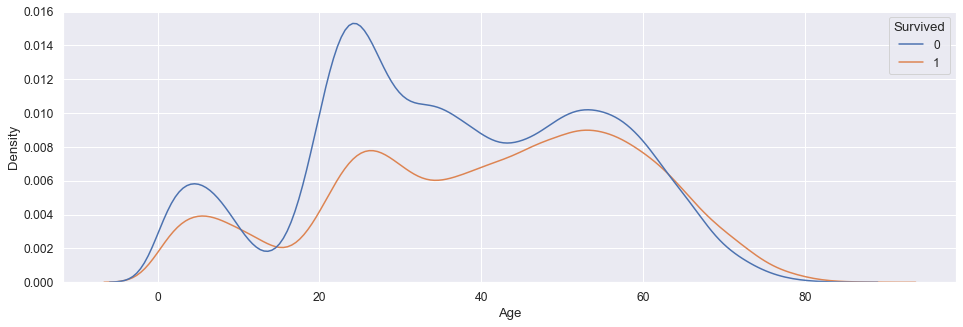

In [43]:
#KDE plot for visualise distribution of survived/not survived passengers
plt.figure(figsize=(16,5))
sns.kdeplot(data=data,x='Age',hue='Survived')

Как видно из распределения, наибольшее число смертей у людей, возраста от 17 до 30 лет, так же есть 2 пика у детей до 10 лет и у взрослых от 50 до 60 лет. Но с учетом того, что подобные пики наблюдаются и у выживших пассажиров, можно сделать вывод, что это просто наиболее распространенные группы людей на борту, а наибольший разрыв приходится на возраст 17-30 лет.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

[Text(0, 0.5, '% выживания'),
 Text(0.5, 0, 'Посадочный порт'),
 Text(0.5, 1.0, 'Распределение выживших по портам')]

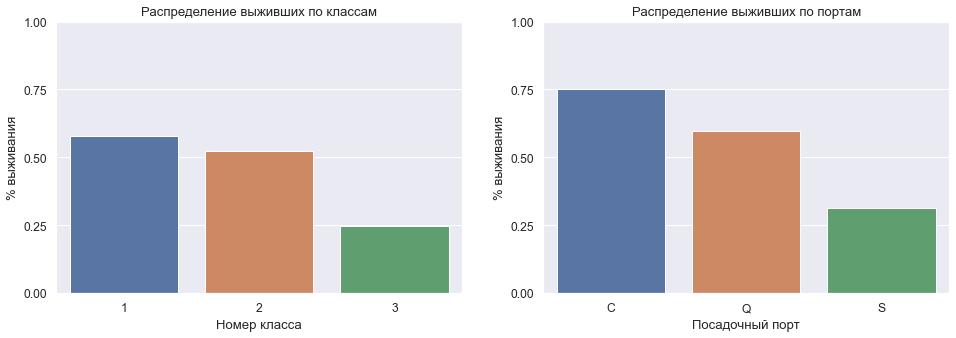

In [44]:
## your code
plt.figure(figsize=(16,5))
df_class =  data[['Survived','Pclass']].groupby('Pclass').agg(['count','mean']).reset_index()
df_emb = data[['Survived','Embarked']].groupby('Embarked').agg(['count','mean']).reset_index()
plt.subplot(1,2,1)
sns.barplot(x=df_class.iloc[:,0],y=df_class.iloc[:,2]).set(ylabel='% выживания', xlabel='Номер класса',\
                                                           yticks=np.linspace(0,1,5),title='Распределение выживших по классам')
plt.subplot(1,2,2)
sns.barplot(x=df_emb.iloc[:,0],y=df_emb.iloc[:,2]).set(ylabel='% выживания', xlabel='Посадочный порт',\
                                                      yticks=np.linspace(0,1,5),title='Распределение выживших по портам')

Исходя из вышестоящих графиков, можно сделать вывод о том, что самым "безопасным" является класс №1 (№2 не сильно далеко ушел) т.к. они являются и самыми дорогими (спасали скорее всего тех, у кого есть деньги и состояние). Соответственно, чаще всего садились богатые люди из порта C и Q.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [45]:
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


In [46]:
## your code
for x in data.columns:
    x = str(x)
    print(f'{x}   -   ' + f'{data[x].isna().sum()/len(data[x])*100} % missing values')

Survived   -   0.0 % missing values
Pclass   -   0.0 % missing values
Name   -   0.0 % missing values
Sex   -   0.0 % missing values
Age   -   3.292 % missing values
SibSp   -   0.0 % missing values
Parch   -   0.0 % missing values
Ticket   -   4.623 % missing values
Fare   -   0.134 % missing values
Cabin   -   67.866 % missing values
Embarked   -   0.25 % missing values


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Для столбцов Age и Fare можно применить замену Nan-values с помощью среднего значения или медианы (с одной стороны - это самый базовый способ, но с другой может потеряться спецефичность такой замены)
Для Ticket и Cabin намного все сложнее, т.к. это какой-то определенный маркер отдельного пассажира 
Embarked иожно заменить путем анализа колонки Fare (<20 у.е. - 3 класс, > 20 и < 100 - 2 класс, > 100 - 1 класс) или просто заменить на самый распространенный порт

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [47]:
## Drop columns with unique values and fill na for Age and Fare by mean value and for Embarked for most common
df = data.drop(['Name','Ticket','Cabin'],axis=1)
df['Age'] = df.Age.fillna(df.Age.mean())
df['Fare'] = df.Fare.fillna(df.Fare.mean())
df['Embarked'] = df.Embarked.fillna(df['Embarked'].value_counts().index.tolist()[0])
df['Sex'].replace(['male','female'],[0,1],inplace=True)
df['Embarked'].replace(['C','Q','S'],[1,2,3],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  int64  
 3   Age       100000 non-null  float64
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Fare      100000 non-null  float64
 7   Embarked  100000 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 8.9 MB


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
X = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
log_model = LogisticRegression(max_iter=500)

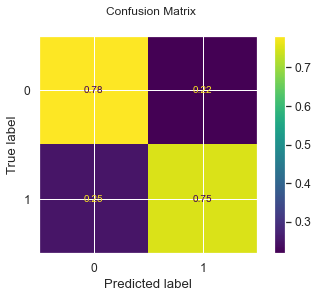

In [55]:
train_acc, test_acc = fit_evaluate(log_model, X_train, y_train, X_test, y_test)

In [56]:
train_acc, test_acc

(0.7662857142857142, 0.7683666666666666)

In [57]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

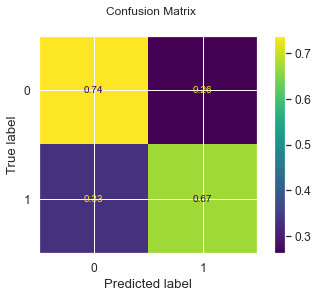

In [58]:
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

In [59]:
train_acc, test_acc

(0.9944428571428572, 0.7093333333333334)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

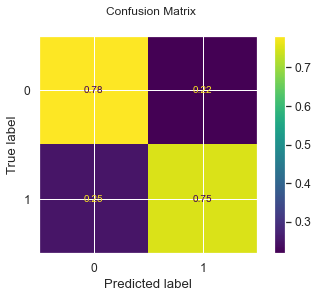

(0.7663285714285715, 0.7684666666666666)

In [62]:
## your code
log_model = LogisticRegression(C=1.5,penalty='l2',solver='liblinear', tol = 1*10**(-6),max_iter=1000)
train_acc_new, test_acc_new = fit_evaluate(log_model, X_train, y_train, X_test, y_test)
train_acc_new, test_acc_new

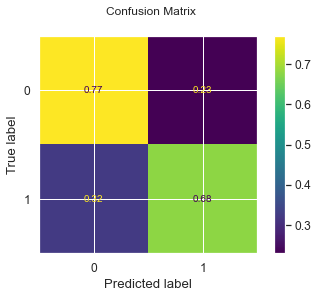

(0.7807571428571428, 0.7313666666666667)

In [64]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
train_acc_knn, test_acc_knn = fit_evaluate(knn, X_train, y_train, X_test, y_test)
train_acc_knn, test_acc_knn

#### По итогу удалось улучшить только knn с учетом увеличения числа соседей для тестовой выборки, а на остальное не хватило времени. Извиняюсь за то, что местами логика покадала данную работу, доделывал за 10 минут до конца дедлайна

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.